In [1]:
words = open('names.txt').read().splitlines()
len(words)

32033

In [2]:
with open('names.txt', 'r') as file:
    words = file.read().splitlines()
len(words)

32033

In [3]:
b = {}
for w in words:
    w = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(w, w[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1


sorted(b.items(), key=lambda x: x[1], reverse=True)[:20]

[(('n', '.'), 6763),
 (('a', '.'), 6640),
 (('a', 'n'), 5438),
 (('.', 'a'), 4410),
 (('e', '.'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('.', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('.', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '.'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('.', 'j'), 2422)]

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}


In [85]:
import torch

N = torch.zeros((27,27), dtype=torch.int32)
for w in words:
    w = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(w, w[1:]):
        bigram = (stoi[ch1], stoi[ch2])
        N[bigram] += 1


# frequency as probability

In [86]:
P = N / N.sum(dim=-1, keepdim=True)

(-0.5, 26.5, 26.5, -0.5)

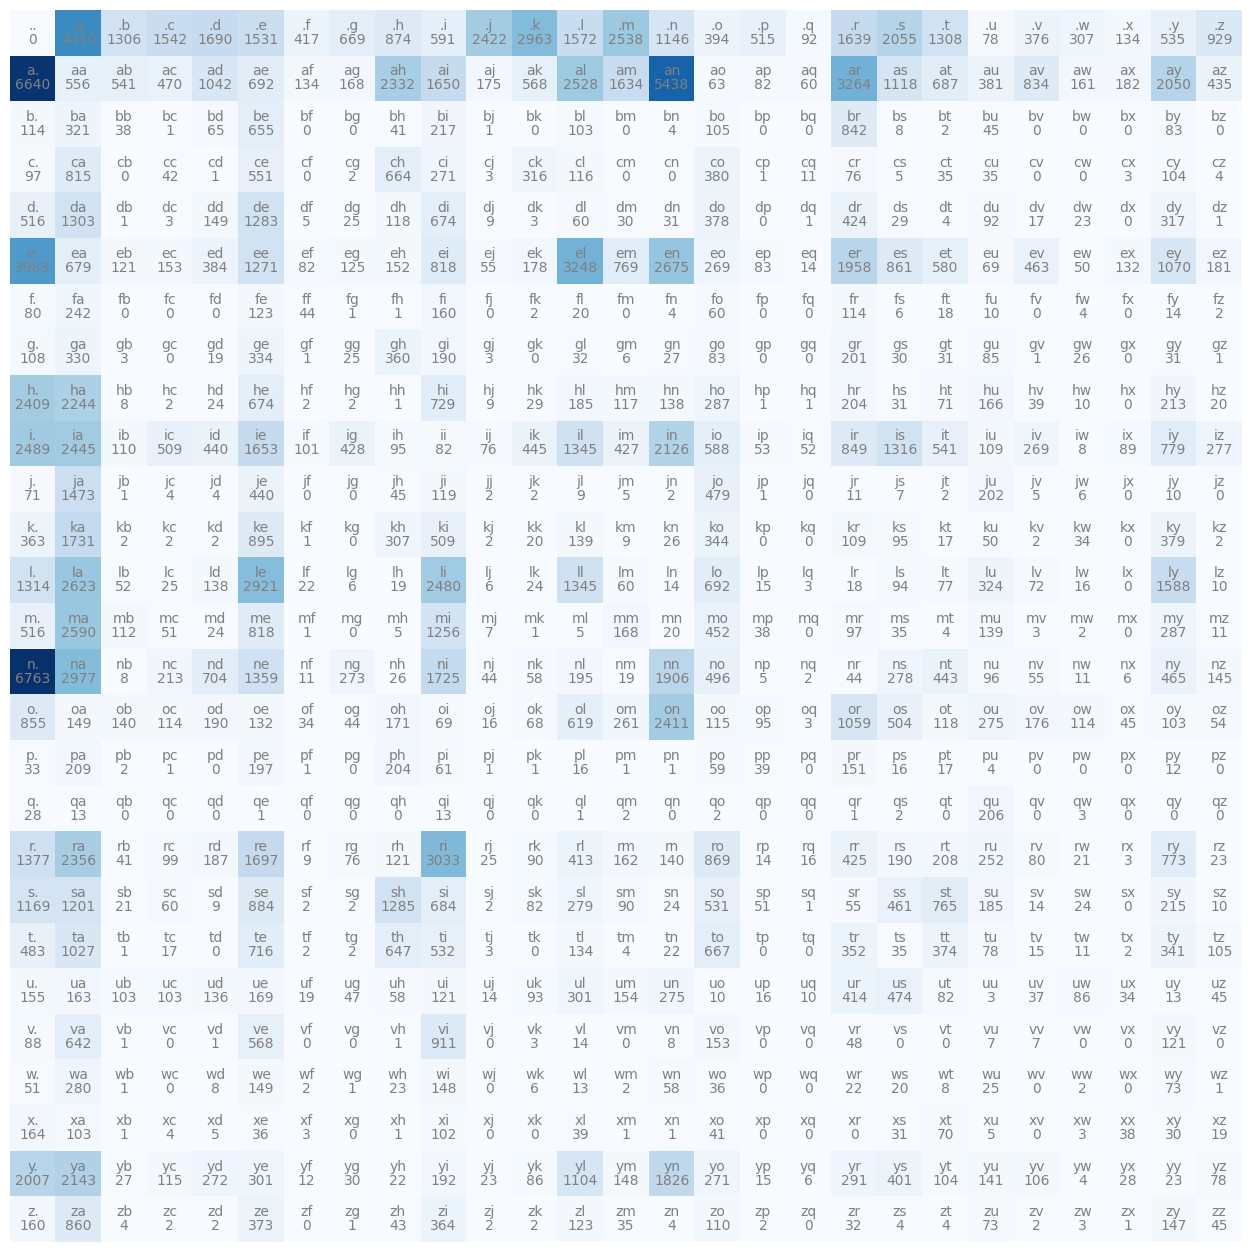

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i,j].item(), ha="center", va="top", color="gray")

plt.axis('off')

In [8]:
g = torch.Generator().manual_seed(42)
for _ in range(10):
    idx = torch.zeros(1, dtype=torch.int32)
    while True:
        prob = P[idx[-1]].float()
        idx_next = torch.multinomial(prob, 1, generator=g)
        # print(f'{itos[idx[-1].item()], itos[idx_next.item()]} next tk prob: {prob[idx_next.item()]}')
        idx = torch.cat([idx, idx_next])
        if idx_next.item() == 0:
            break
    print(''.join(itos[i.item()] for i in idx))


.anugeenvi.
.s.
.mabian.
.dan.
.stan.
.silaylelaremah.
.li.
.le.
.epiachalen.
.diza.


In [9]:
nll = 0.0
n = 0
for w in ['xiaojq']:
    w = ['.'] + list(w) + ['.']
    for tk, next_tk in zip(w, w[1:]):
        prob = P[stoi[tk], stoi[next_tk]]
        print(f'{tk}{next_tk} prob: {prob:.4f} nll: {-prob.log():.4f}')
        nll += -prob.log()
        n += 1
print(f'{nll=}')
f'{nll/n=}'

.x prob: 0.0042 nll: 5.4767
xi prob: 0.1463 nll: 1.9218
ia prob: 0.1381 nll: 1.9796
ao prob: 0.0019 nll: 6.2876
oj prob: 0.0020 nll: 6.2063
jq prob: 0.0000 nll: inf
q. prob: 0.1029 nll: 2.2736
nll=tensor(inf)


'nll/n=tensor(inf)'

# use neural network to learn probability

In [80]:
import random

# train set
random.seed(42)
random.shuffle(words)
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(stoi[ch1])
        ys.append(stoi[ch2])
xs = torch.tensor(xs)
ys = torch.tensor(ys)

## use off-the-shelf torch api

### minibatch

In [90]:
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(42)
net = nn.Sequential(
    nn.Embedding(27, 27),
    # nn.GELU(),
    # nn.Linear(27, 27),
)
optimizer = torch.optim.AdamW(net.parameters(), lr=0.01)
data = list(zip(xs, ys))
n = int(len(data) * 0.95)
train_data, val_data = data[:n], data[n:]
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=512)

for epoch in range(3):
    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True) # re-shuffle
    for step, (xb, yb) in enumerate(train_dataloader):
        loss = F.cross_entropy(net(xb), yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step % 100 == 0:
            with torch.no_grad():
                val_loss = 0.0
                num = 0
                for xb, yb in val_dataloader:
                    val_loss += F.cross_entropy(net(xb), yb)
                    num += 1
                val_loss /= num
            print(f'epoch {epoch} step {step} train loss: {loss:.4f} val loss: {val_loss:.4f}')



epoch 0 step 0 train loss: 3.7220 val loss: 3.6966
epoch 0 step 100 train loss: 3.0112 val loss: 3.0609
epoch 0 step 200 train loss: 2.7193 val loss: 2.7524
epoch 0 step 300 train loss: 2.4915 val loss: 2.6032
epoch 0 step 400 train loss: 2.5182 val loss: 2.5379
epoch 0 step 500 train loss: 2.4912 val loss: 2.5058
epoch 0 step 600 train loss: 2.5282 val loss: 2.4888
epoch 0 step 700 train loss: 2.4567 val loss: 2.4807
epoch 0 step 800 train loss: 2.3322 val loss: 2.4763
epoch 0 step 900 train loss: 2.3373 val loss: 2.4720
epoch 0 step 1000 train loss: 2.6028 val loss: 2.4691
epoch 0 step 1100 train loss: 2.3468 val loss: 2.4671
epoch 0 step 1200 train loss: 2.6121 val loss: 2.4660
epoch 0 step 1300 train loss: 2.6134 val loss: 2.4645
epoch 0 step 1400 train loss: 2.5236 val loss: 2.4643
epoch 0 step 1500 train loss: 2.5304 val loss: 2.4628
epoch 0 step 1600 train loss: 2.6090 val loss: 2.4624
epoch 1 step 0 train loss: 2.6159 val loss: 2.4624
epoch 1 step 100 train loss: 2.4286 val los

### full batch

In [132]:
torch.manual_seed(42)
net = nn.Sequential(
    nn.Embedding(27, 27),
)
optimizer = torch.optim.AdamW(net.parameters(), lr=1)
data = list(zip(xs, ys))
n = int(len(data) * 0.95)
train_data, val_data = data[:n], data[n:]
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=len(val_data))

for epoch in range(100):
    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=len(train_data), shuffle=True) # re-shuffle
    for step, (xb, yb) in enumerate(train_dataloader):
        loss = F.cross_entropy(net(xb), yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step % 100 == 0:
            with torch.no_grad():
                val_loss = 0.0
                num = 0
                for xb, yb in val_dataloader:
                    val_loss += F.cross_entropy(net(xb), yb)
                    num += 1
                val_loss /= num
            print(f'epoch {epoch} step {step} train loss: {loss:.4f} val loss: {val_loss:.4f}')



epoch 0 step 0 train loss: 3.6963 val loss: 2.9212
epoch 1 step 0 train loss: 2.9134 val loss: 2.6313
epoch 2 step 0 train loss: 2.6252 val loss: 2.5923
epoch 3 step 0 train loss: 2.5881 val loss: 2.6122
epoch 4 step 0 train loss: 2.6114 val loss: 2.6312
epoch 5 step 0 train loss: 2.6348 val loss: 2.6215
epoch 6 step 0 train loss: 2.6279 val loss: 2.5951
epoch 7 step 0 train loss: 2.6029 val loss: 2.5730
epoch 8 step 0 train loss: 2.5805 val loss: 2.5594
epoch 9 step 0 train loss: 2.5656 val loss: 2.5511
epoch 10 step 0 train loss: 2.5554 val loss: 2.5456
epoch 11 step 0 train loss: 2.5478 val loss: 2.5396
epoch 12 step 0 train loss: 2.5397 val loss: 2.5320
epoch 13 step 0 train loss: 2.5303 val loss: 2.5233
epoch 14 step 0 train loss: 2.5206 val loss: 2.5147
epoch 15 step 0 train loss: 2.5119 val loss: 2.5080
epoch 16 step 0 train loss: 2.5059 val loss: 2.5039
epoch 17 step 0 train loss: 2.5030 val loss: 2.5003
epoch 18 step 0 train loss: 2.5005 val loss: 2.4954
epoch 19 step 0 train 

In [21]:
# bigram val loss
N = torch.zeros((27,27), dtype=torch.int32)
for x, y in train_data:
    N[x, y] += 1
P = N / N.sum(dim=-1, keepdim=True)

val_loss = 0.0
num = 0
for x, y in val_data:
    val_loss += -P[x, y].log()
    num += 1
val_loss /= num
print(f'bigram val loss: {val_loss:.4f}')


bigram val loss: 2.4539


In [169]:
g = torch.Generator().manual_seed(42)
for _ in range(10):
    idx = torch.zeros(1, dtype=torch.int32)
    while True:
        prob = net(idx[-1]).softmax(dim=-1)
        idx_next = torch.multinomial(prob, 1, generator=g)
        # print(f'{itos[idx[-1].item()], itos[idx_next.item()]} next tk prob: {prob[idx_next.item()]}')
        idx = torch.cat([idx, idx_next])
        if idx_next.item() == 0:
            break
    print(''.join(itos[i.item()] for i in idx))


.anugeenvi.
.s.
.mabidushan.
.stan.
.silaylelaremah.
.li.
.le.
.epiachalen.
.diza.
.k.


same as sampling from frequency bigram

In [135]:
g = torch.Generator().manual_seed(42)
for _ in range(10):
    idx = torch.zeros(1, dtype=torch.int32)
    while True:
        prob = P[idx[-1]].float()
        idx_next = torch.multinomial(prob, 1, generator=g)
        # print(f'{itos[idx[-1].item()], itos[idx_next.item()]} next tk prob: {prob[idx_next.item()]}')
        idx = torch.cat([idx, idx_next])
        if idx_next.item() == 0:
            break
    print(''.join(itos[i.item()] for i in idx))


.anugeenvi.
.s.
.mabidushan.
.stan.
.silaylelaremah.
.li.
.le.
.epiachalen.
.diza.
.k.


(-0.5, 26.5, 26.5, -0.5)

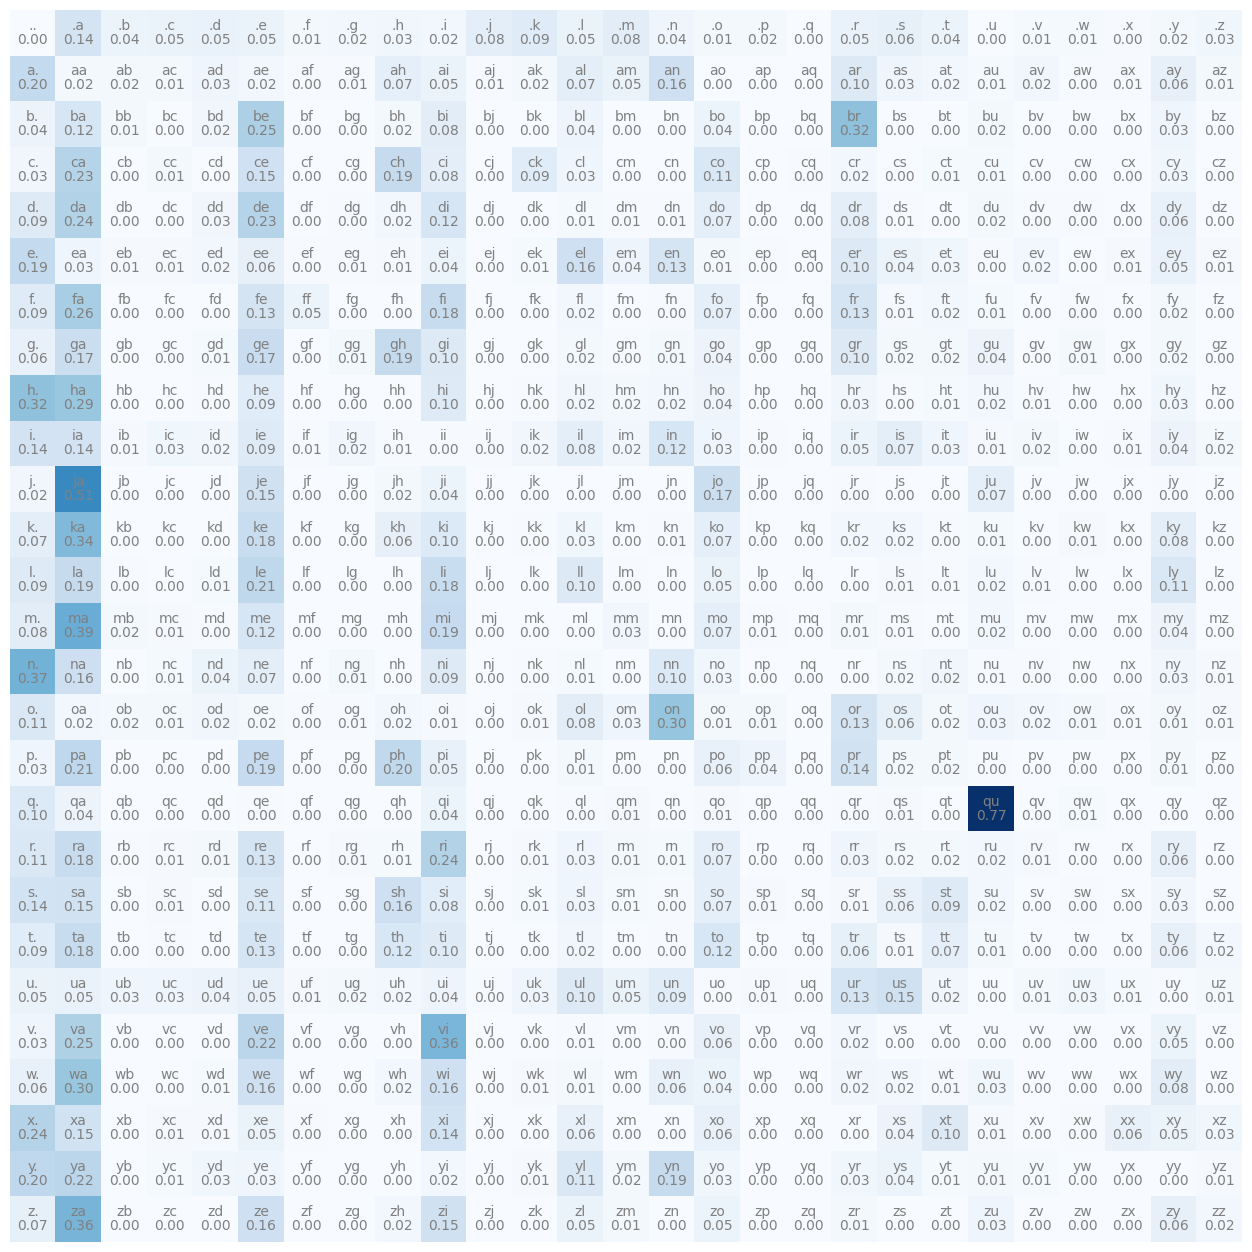

In [136]:
import matplotlib.pyplot as plt
%matplotlib inline

netP = net(torch.arange(27)).softmax(dim=-1).detach().numpy()
plt.figure(figsize=(16,16))
plt.imshow(netP, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, f'{netP[i,j]:.2f}', ha="center", va="top", color="gray")

plt.axis('off')


(-0.5, 26.5, 26.5, -0.5)

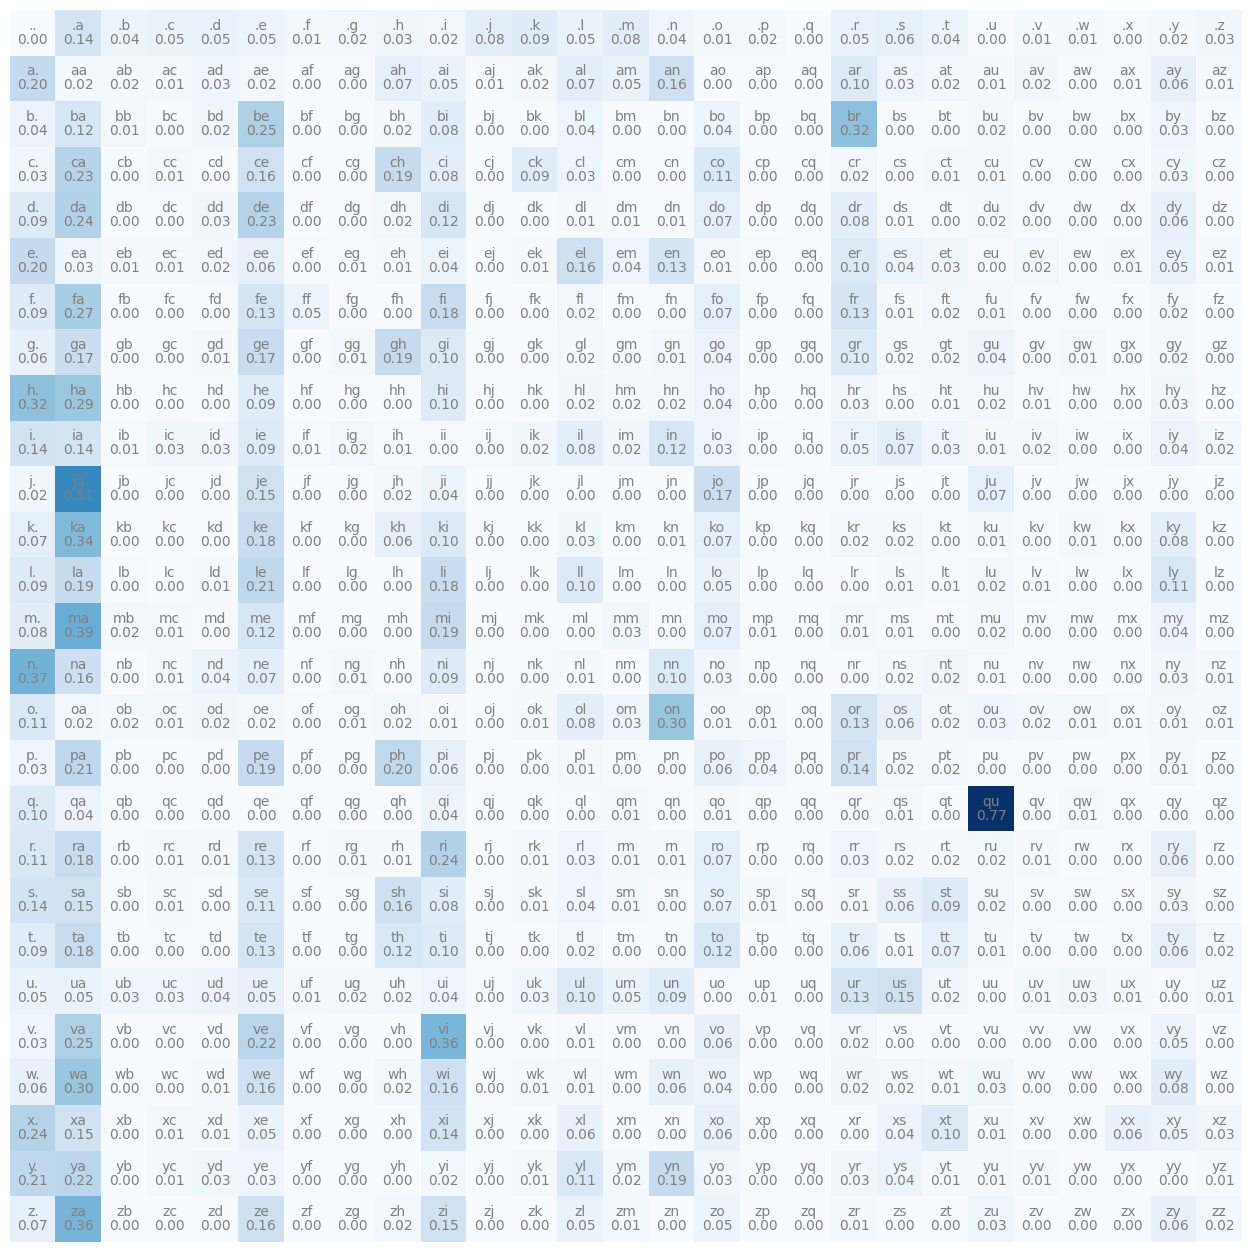

In [121]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(P, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, f'{P[i,j].item():.2f}', ha="center", va="top", color="gray")

plt.axis('off')

In [142]:
torch.allclose(torch.from_numpy(netP), P, atol=1e-2), torch.allclose(torch.from_numpy(netP), P, atol=1e-3)


(True, False)

## use neural network from matrix multiplication

In [170]:
# from scratch
g = torch.Generator().manual_seed(42)
W = torch.randn((27, 27), requires_grad=True, generator=g)


n = int(len(xs) * 0.95)
xs, ys = torch.tensor(xs), torch.tensor(ys)

def cal_loss(xb, yb):
    xb = F.one_hot(xb, num_classes=27).float()
    logits = xb @ W
    exp_lg = logits.exp()
    probs = exp_lg / exp_lg.sum(dim=-1, keepdim=True)
    loss = -probs.gather(1, yb.unsqueeze(-1)).log().mean()
    return loss

lr = 50.0
num_epochs = 5000
for epoch in range(num_epochs):
    loss = cal_loss(xs[:n], ys[:n])
    # update
    loss.backward()
    W.data -= lr * W.grad
    W.grad = None
    if epoch % 100 == 0:
        with torch.no_grad():
            eval_loss = cal_loss(xs[n:], ys[n:])
        print(f'epoch {epoch} loss: {loss:.4f} eval loss: {eval_loss:.4f}')




/var/folders/0r/_r1qbh850_g0pzpgx1lg9_q40000gn/T/ipykernel_86439/3975757651.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xs, ys = torch.tensor(xs), torch.tensor(ys)


epoch 0 loss: 3.6963 eval loss: 3.3701
epoch 100 loss: 2.4729 eval loss: 2.4742
epoch 200 loss: 2.4626 eval loss: 2.4636
epoch 300 loss: 2.4594 eval loss: 2.4600
epoch 400 loss: 2.4579 eval loss: 2.4583
epoch 500 loss: 2.4570 eval loss: 2.4574
epoch 600 loss: 2.4564 eval loss: 2.4567
epoch 700 loss: 2.4561 eval loss: 2.4563
epoch 800 loss: 2.4558 eval loss: 2.4560
epoch 900 loss: 2.4556 eval loss: 2.4557
epoch 1000 loss: 2.4554 eval loss: 2.4555
epoch 1100 loss: 2.4553 eval loss: 2.4553
epoch 1200 loss: 2.4552 eval loss: 2.4552
epoch 1300 loss: 2.4551 eval loss: 2.4551
epoch 1400 loss: 2.4550 eval loss: 2.4550
epoch 1500 loss: 2.4549 eval loss: 2.4549
epoch 1600 loss: 2.4549 eval loss: 2.4548
epoch 1700 loss: 2.4548 eval loss: 2.4547
epoch 1800 loss: 2.4548 eval loss: 2.4547
epoch 1900 loss: 2.4547 eval loss: 2.4546
epoch 2000 loss: 2.4547 eval loss: 2.4546
epoch 2100 loss: 2.4547 eval loss: 2.4545
epoch 2200 loss: 2.4546 eval loss: 2.4545
epoch 2300 loss: 2.4546 eval loss: 2.4545
epoc

(-0.5, 26.5, 26.5, -0.5)

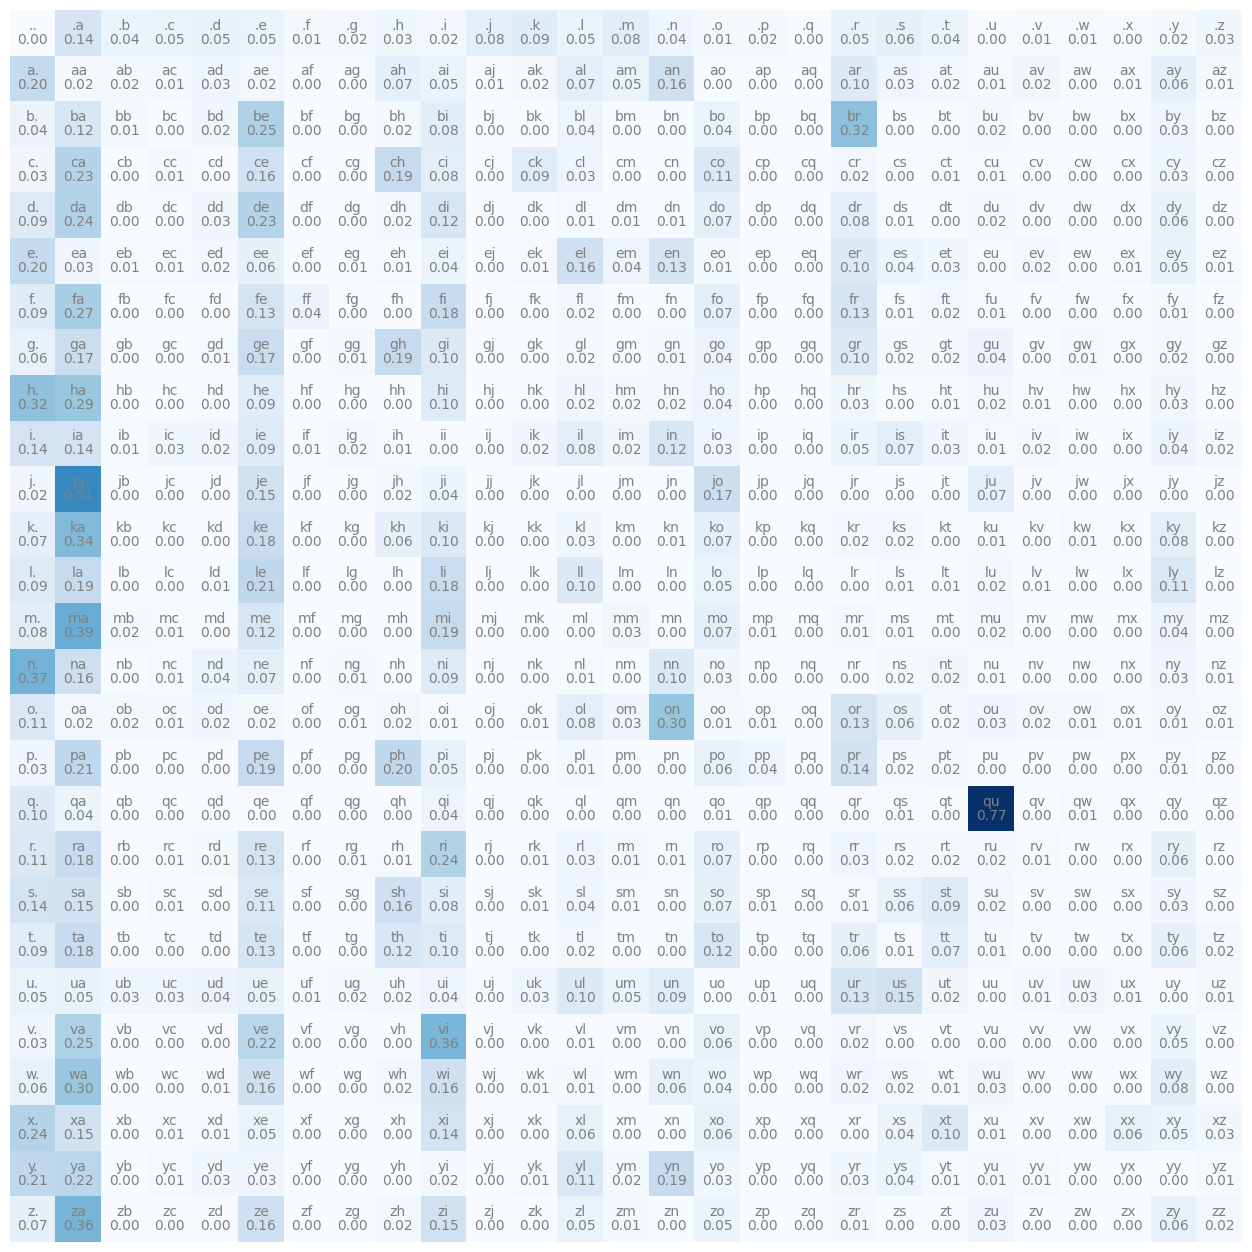

In [171]:
import matplotlib.pyplot as plt
%matplotlib inline

PW = W.detach().softmax(dim=-1)

plt.figure(figsize=(16,16))
plt.imshow(PW.numpy(), cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, f'{PW[i,j].item():.2f}', ha="center", va="top", color="gray")

plt.axis('off')

In [172]:
g = torch.Generator().manual_seed(42)
for _ in range(10):
    idx = torch.zeros(1, dtype=torch.int32)
    while True:
        prob = PW[idx[-1]].float()
        idx_next = torch.multinomial(prob, 1, generator=g)
        # print(f'{itos[idx[-1].item()], itos[idx_next.item()]} next tk prob: {prob[idx_next.item()]}')
        idx = torch.cat([idx, idx_next])
        if idx_next.item() == 0:
            break
    print(''.join(itos[i.item()] for i in idx))


.anugeenvi.
.s.
.mabidushan.
.stan.
.silaylelaremah.
.li.
.le.
.epiachalen.
.diza.
.k.


In [176]:
torch.allclose(PW, P, atol=1e-2), torch.allclose(PW, P, atol=1e-3)

(True, False)

## use micrograd from scratch

this is slow, but it is a good exercise

In [15]:
# use micrograd from scratch
import random
from micrograd import Value

random.seed(42)
random.shuffle(words)
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(stoi[ch1])
        ys.append(stoi[ch2])
data = list(zip(xs, ys))
n = int(len(data) * 0.95)
train_data, val_data = data[:n], data[n:]

def cal_loss(xb, yb):
    logits = [W[xb[i]] for i in range(len(xb))] # (bs, 27)
    exp_logits = [[lg.exp() for lg in logit] for logit in logits]
    sum_exp_logits = [sum(exp_logit) for exp_logit in exp_logits] # (bs,)
    probs = [exp_logit[y] / sum_exp_logit for exp_logit, sum_exp_logit, y in zip(exp_logits, sum_exp_logits, yb)]
    loss = sum([-prob.log() for prob in probs]) / len(probs)
    return loss


random.seed(42)
W = [[Value(random.gauss(0,1)) for _ in range(27)] for _ in range(27)]

lr = 50
bs = 1084

step = 0
for epoch in range(3):
    random.shuffle(train_data)
    for idx in range(0, len(train_data), bs):
        xb, yb = zip(*train_data[idx:idx+bs])
        loss = cal_loss(xb, yb)
        # update
        loss.backward()
        for params in W:
            for p in params:
                p.data -= lr * p.grad
                p.grad = 0.0
        step += 1
        lr = max(50 * (1 - 0.9 * step / 200), 5.0)
        if step % 10 == 0:
            xb, yb = zip(*val_data[:bs]) # one batch for efficiency
            val_loss = cal_loss(xb, yb)
            print(f'epoch {epoch} step {step} loss: {loss.data:.4f} val loss: {val_loss.data:.4f}')


epoch 0 step 10 loss: 2.7057 val loss: 2.6831
epoch 0 step 20 loss: 2.6022 val loss: 2.5913
epoch 0 step 30 loss: 2.5234 val loss: 2.5405
epoch 0 step 40 loss: 2.4698 val loss: 2.5150
epoch 0 step 50 loss: 2.5522 val loss: 2.5127
epoch 0 step 60 loss: 2.5180 val loss: 2.5082
epoch 0 step 70 loss: 2.4518 val loss: 2.4994
epoch 0 step 80 loss: 2.4859 val loss: 2.4927
epoch 0 step 90 loss: 2.4741 val loss: 2.4960
epoch 0 step 100 loss: 2.5461 val loss: 2.4931
epoch 0 step 110 loss: 2.5152 val loss: 2.4921
epoch 0 step 120 loss: 2.4099 val loss: 2.4882
epoch 0 step 130 loss: 2.5279 val loss: 2.4862
epoch 0 step 140 loss: 2.4381 val loss: 2.4807
epoch 0 step 150 loss: 2.5180 val loss: 2.4828
epoch 0 step 160 loss: 2.4602 val loss: 2.4806
epoch 0 step 170 loss: 2.4504 val loss: 2.4787
epoch 0 step 180 loss: 2.4519 val loss: 2.4820
epoch 0 step 190 loss: 2.4861 val loss: 2.4808
epoch 0 step 200 loss: 2.4713 val loss: 2.4795
epoch 1 step 210 loss: 2.4818 val loss: 2.4783
epoch 1 step 220 loss:

(-0.5, 26.5, 26.5, -0.5)

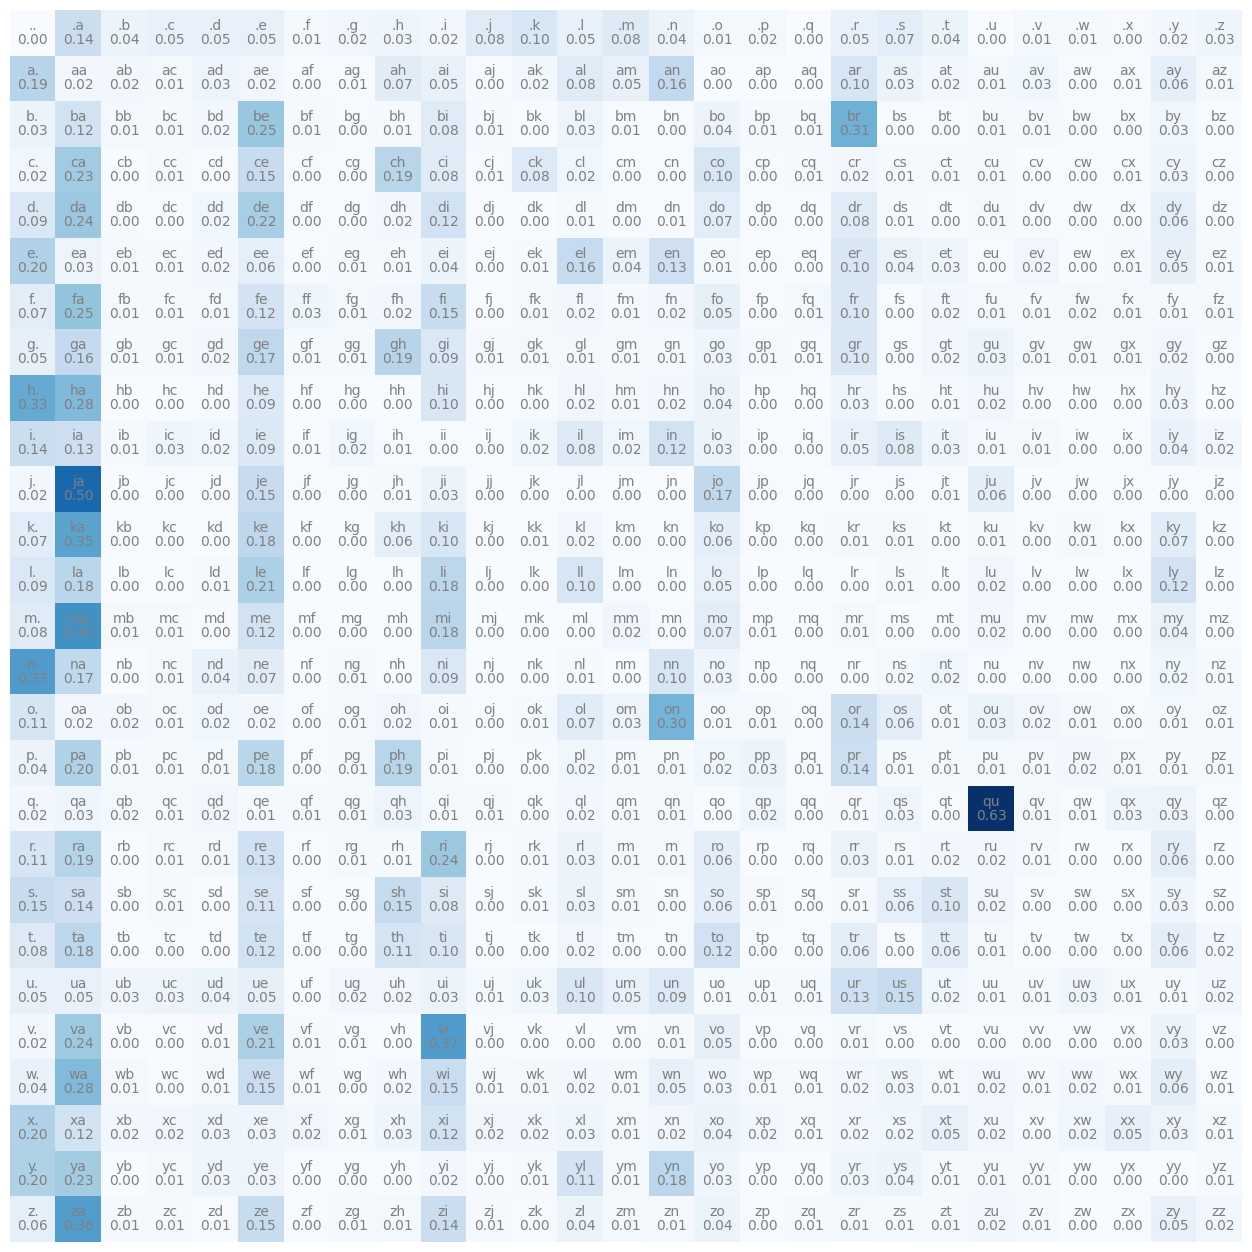

In [18]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

W_data = [[w.data for w in params] for params in W]
PW = torch.tensor(W_data).softmax(dim=-1)

plt.figure(figsize=(16,16))
plt.imshow(PW.numpy(), cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, f'{PW[i,j].item():.2f}', ha="center", va="top", color="gray")

plt.axis('off')

almost same as sampling from frequency bigram

In [30]:
g = torch.Generator().manual_seed(42)
for _ in range(10):
    idx = torch.zeros(1, dtype=torch.int32)
    while True:
        prob = PW[idx[-1]].float()
        idx_next = torch.multinomial(prob, 1, generator=g)
        # print(f'{itos[idx[-1].item()], itos[idx_next.item()]} next tk prob: {prob[idx_next.item()]}')
        idx = torch.cat([idx, idx_next])
        if idx_next.item() == 0:
            break
    print(''.join(itos[i.item()] for i in idx))


.anugeenvi.
.s.
.mabidushan.
.stan.
.silaylelaremah.
.li.
.le.
.epenchalen.
.diza.
.k.


In [29]:
torch.allclose(PW, P, atol=0.2), torch.allclose(PW, P, atol=0.1)


(True, False)